In [1]:
import os
import random

import numpy
import pandas
import matplotlib
from matplotlib import pyplot
import seaborn

import editdistance
import logomaker

# import nupack

In [2]:
%matplotlib inline
matplotlib.rcParams['figure.dpi'] = 120
matplotlib.rcParams['font.sans-serif'] = 'Helvetica'
pandas.set_option('display.max_colwidth', -1)

C:\Users\casti\AppData\Local\Temp\ipykernel_16904\500457552.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pandas.set_option('display.max_colwidth', -1)


In [3]:
# Helper functions
def one_hot_encode(sequences, seq_len=100):
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'a':[1,0,0,0],
             'c':[0,1,0,0],
             'g':[0,0,1,0],
             't':[0,0,0,1],
             'n':[0,0,0,0]}
    
    # Creat empty matrix
    vectors = numpy.empty([len(sequences), seq_len, 4])
    
    # Iterate through sequences and one-hot encode
    for i, seq in enumerate(sequences): 
        seq = seq[:seq_len].lower()
        a = numpy.array([nuc_d[x] for x in seq])
        vectors[i] = a
    return vectors

In [4]:
def plot_pwm(seq, title=None):
    pwm = one_hot_encode([seq], seq_len=len(seq))[0]
    # Calculate entropy and conservation
    entropy = numpy.zeros_like(pwm)
    entropy[pwm > 0] = pwm[pwm > 0] * -numpy.log2(pwm[pwm > 0])
    entropy = numpy.sum(entropy, axis=1)
    conservation = 2 - entropy
    # Nucleotide height
    nt_height = numpy.tile(numpy.reshape(conservation, (-1, 1)), (1, 4))
    nt_height = pwm * nt_height

    nt_height_df = pandas.DataFrame(
        nt_height,
        columns=['A', 'C', 'G', 'T'],
    )

    fig = pyplot.figure(figsize=(len(seq)/5., 0.4))
    ax = fig.add_subplot(1, 1, 1)
    logo = logomaker.Logo(
        nt_height_df,
        color_scheme='classic',
        ax=ax,
    )
    logo.style_spines(visible=False)
    logo.style_spines(spines=['bottom'], visible=True, linewidth=2)
    ax.set_xticks([])
    ax.set_yticks([])
    if title is not None:
        ax.set_title(title)

In [5]:
# Calculate random pair-wise edit distances
def sample_editdistance(seqs, n_samples=500, seed=None):

    if seed is not None:
        random.seed(seed)

    distances = []
    for i in range(n_samples):
        seq_1 = random.choice(seqs)
        seq_2 = seq_1
        while(seq_1 == seq_2):
            seq_2 = random.choice(seqs)
        dist = editdistance.eval(seq_1, seq_2)
        distances.append(dist)

    distances = numpy.array(distances) / len(seqs[0])

    return distances

In [6]:
def violinplot(ax, data, pos, color):
    vp = ax.violinplot(data, [pos], showextrema=False,)
    for body in vp['bodies']:
        body.set_alpha(0.9)
        body.set_facecolor(color)
        body.set_edgecolor('k')
    return vp

In [7]:
# 4 sequences with varied MRL from Inverse regression DEN, 50nt utr
design_data_folder = '../den/'
design_data_filename = 'genesis_invreg_optimus5p_50bp_ns_sequences.csv'
mpra_data_filename = "../../polysome_profiling_sample2019/GSM3130435_egfp_unmod_1.csv.gz"

In [8]:
# Load sequences
design_data_path = os.path.join(design_data_folder, design_data_filename)
design_data = pandas.read_csv(design_data_path)

In [9]:
# Remove sequences starting with TG
design_data_filtered = design_data[~(design_data['utr'].str[:2]=='TG')]
# Remove sequences with in-frame ATGs
idx_not_in_frame_atg = []
for idx, row in design_data_filtered.iterrows():
    seq = row['utr']
    in_frame_atg = False
    for pos in range(-3, -len(seq)-1, -3):
        if pos==-3:
            if seq[-3:]=='ATG':
                in_frame_atg = True
                break
        else:
            if seq[pos: pos+3]=='ATG':
                in_frame_atg = True
                break
    if not in_frame_atg:
        idx_not_in_frame_atg.append(idx)
design_data_filtered = design_data_filtered.loc[idx_not_in_frame_atg]
print("{}/{} sequences retained...".format(len(design_data_filtered), len(design_data)))

1015/1024 sequences retained...


,utr,rl
96,CATCCCGGTCGCCATGGCTGGGTGTCCCCATCCGCGTCCCCAACAATGGC,1.994527
295,CATCAAGGCGTGTCCCCATTAGGGCAGGTGTCCCCATCAATGCTGGGTAT,3.499113
522,CATCAAGGTGTCTCCATCAAGGATAGGCCTGGCTCATCAAGGCTCGGTGT,5.011988
715,GTACGGCAGTACGGTGTCACCATTACGTGCTAGGTGTCACCATTTAGTAT,6.500868


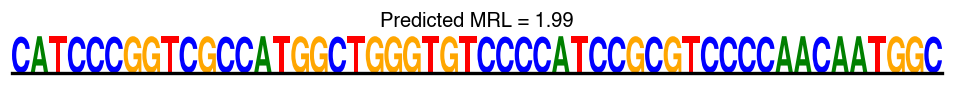

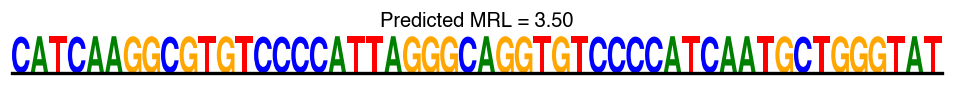

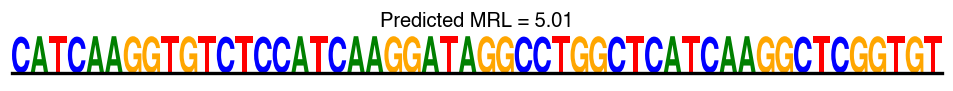

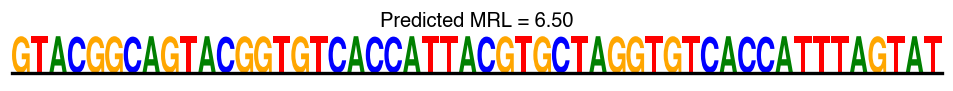

In [10]:
# Select sequences
target_mrls = numpy.linspace(2, 8, 5)[:-1]
design_data_indices = [((design_data_filtered['rl'] - target_mrl)**2).argmin()
                for target_mrl in target_mrls]
design_data_selected = design_data_filtered.iloc[design_data_indices]

# Plot sequences
for index, row in design_data_selected.iterrows():
    plot_pwm(
        row['utr'],
        title="Predicted MRL = {:.2f}".format(row['rl']),
    )
    
design_data_selected

In [11]:
# Load MPRA library to make comparison plot
mpra_data = pandas.read_csv(mpra_data_filename)
mpra_data = mpra_data[mpra_data['total_reads'] > 1000]
mpra_data

,Unnamed: 0,utr,0,1,2,3,4,5,6,7,...,r5,r6,r7,r8,r9,r10,r11,r12,r13,rl
0,120605,CCACTCGATTAACATGTTAACAACATACTCGTCCGGCCGATCAGCGGCTA,1.365472e-04,1.090036e-04,5.717043e-05,0.000033,0.000015,0.000016,0.000009,9.186945e-06,...,0.033645,0.020343,0.019850,0.017988,0.019283,0.033252,0.033252,0.027581,0.035877,3.039939
1,11605,CAAATCATGTGCAGCCCTGGCGACCGTACTGCGGTACAAGAAAGTATAGT,6.661179e-05,6.952406e-05,6.474759e-05,0.000048,0.000023,0.000020,0.000011,1.084524e-05,...,0.049711,0.028540,0.027431,0.024766,0.024241,0.039457,0.039457,0.039840,0.038785,3.895109
2,128224,GTTATACTAGAAGAAACTTGAGATTATGGAGCAGTCCGTCAAGGACGCGA,8.798774e-05,8.087227e-05,5.913157e-05,0.000035,0.000017,0.000016,0.000009,9.485438e-06,...,0.042436,0.022460,0.025015,0.024275,0.021591,0.028353,0.028353,0.028963,0.041985,3.334524
3,239107,CTTAGACAAAAACAACGCGCTTTCCAGTATGCGGAGCCTTGACGGTAAAC,7.773708e-05,7.108933e-05,5.999329e-05,0.000038,0.000025,0.000016,0.000010,8.589960e-06,...,0.041241,0.025793,0.022751,0.022632,0.026617,0.038302,0.038302,0.032788,0.031043,3.575082
4,59082,GTATCAAATCACGGCCAACCCGACGGAGTACCCCGCGTCGATGGTCCGCC,4.373148e-05,4.452323e-05,5.048470e-05,0.000051,0.000033,0.000026,0.000015,1.223821e-05,...,0.071306,0.040719,0.033335,0.030367,0.033080,0.051449,0.051449,0.046052,0.036447,4.593712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145085,208443,TGGTTTGCGACAAGGTGAATCGTGTTAAGCTAAAGCGTGTTATCAAGGAA,4.548074e-07,6.956754e-07,1.753147e-06,0.000002,0.000002,0.000004,0.000004,4.145733e-06,...,0.094477,0.093560,0.100875,0.066926,0.108574,0.077968,0.077968,0.112517,0.085556,7.688016
145086,171450,GGTGTGTGGTTAGTGGGGGGTGCACCCGGTGTTCAACGATAAGTATGGCG,2.169081e-06,1.608749e-06,1.337146e-06,0.000001,0.000001,0.000002,0.000004,3.847241e-06,...,0.060639,0.106241,0.094001,0.092293,0.119454,0.090655,0.090655,0.057670,0.102617,7.483175
145087,100024,AGCTTGTGCCCGGGTTAAGATGGATGCTGCCTCTCGCCACGAAGGAGCGC,8.256504e-06,6.391518e-06,6.240015e-06,0.000003,0.000002,0.000002,0.000001,8.623126e-07,...,0.049720,0.029441,0.022789,0.026168,0.026661,0.047913,0.047913,0.024187,0.036138,3.712467
145088,171731,CCCAACCCATGTCTATTGCCAAGGTCCGAGGCGTTCTGAGCCTAAGCGGT,1.399407e-06,8.695943e-07,7.725733e-07,0.000001,0.000002,0.000002,0.000002,3.150757e-06,...,0.052324,0.048682,0.074883,0.149044,0.163225,0.082168,0.082168,0.087006,0.118388,8.154002


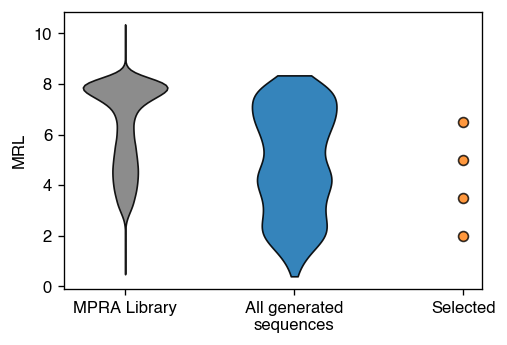

In [12]:
fig, ax = pyplot.subplots(figsize=(4.5, 3.))

violinplot(ax, mpra_data['rl'], 0, 'gray')

violinplot(ax, design_data['rl'], 1, 'tab:blue')

ax.scatter(
    [2]*len(design_data_selected) + 0.0*numpy.random.rand(len(design_data_selected)),
    design_data_selected['rl'],
    linewidth=1,
    color='tab:orange',
    marker='o',
    s=35,
    alpha=0.8,
    edgecolors='k',
)
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['MPRA Library', 'All generated\nsequences', 'Selected'])
ax.set_ylabel('MRL')
fig.savefig(os.path.splitext(design_data_filename)[0] + '_mrl_violins.png', dpi=200, bbox_inches='tight')
fig.savefig(os.path.splitext(design_data_filename)[0] + '_mrl_violins.svg', dpi=200, bbox_inches='tight')

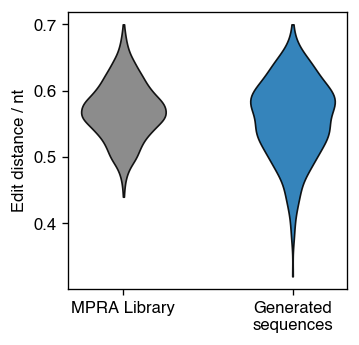

In [13]:
# Plot edit distance across MPRA and designed sequences
mpra_distance = sample_editdistance(mpra_data['utr'].tolist())
design_distance = sample_editdistance(design_data['utr'].tolist())

fig, ax = pyplot.subplots(figsize=(3., 3.))

violinplot(ax, mpra_distance, 0, 'gray')

violinplot(ax, design_distance, 1, 'tab:blue')

ax.set_xticks([0, 1])
ax.set_xticklabels(['MPRA Library', 'Generated\nsequences'])
ax.set_ylabel('Edit distance / nt')
fig.savefig(os.path.splitext(design_data_filename)[0] + '_editdist_violins.png', dpi=200, bbox_inches='tight')
fig.savefig(os.path.splitext(design_data_filename)[0] + '_editdist_violins.svg', dpi=200, bbox_inches='tight')

,utr,rl
10,CGTCCCCATGTGTCCCCCAAAATGGATAACCATGAGTCCCCAGAGATGGC,0.957473
13,GCCAGGTGTCGCCATGAGTCCCCACGGGCCCGGGTCCCCAATAATGGCTT,0.976357
34,ATGGAAATGGAGCGTCACCATGGCTATGCGACCCCAAACATGGATCCTAG,1.424398
65,ACAATGGAAATGGATCCTATGACCATGGACATGGACCCCGTCACCATGGA,1.806777
75,GGCTAGGCCATGATGAAGATGGATAATGCTGGCGTCCCCACGTGTCCCCA,1.870130
77,GTCAAAAAAATGGAGCCTTATCCCCGCGGGGGCGGCAAAATGGATGGCAT,1.876864
85,CGGTCTACAATGGAAATGGCGTCTTTCACCATGGACCGGGCGTCGCCCCG,1.931089
127,GTCAAGCTGGCAACAATGTGTCCCCGTCGCCATGACACCCCGCGTCCCGG,2.138915
148,CATCTGTCCCCATCCGGAACAATGGATCGCCAGGCGTCCCCAAAAATGGC,2.271286
163,GGCAGGCGGGCGTCCCCACGGGATGATGTCTGCAATATGGAAATGGACAT,2.395808


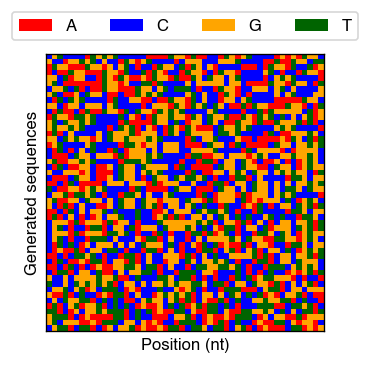

In [14]:
# Plot generated sequences as colormaps
seqs_to_plot = design_data.sample(50)
seqs_to_plot = seqs_to_plot.sort_values('rl', ascending=True)
display(seqs_to_plot)
seqs_to_plot = seqs_to_plot['utr'].tolist()


# Convert sequences to numerical indices
seqs_as_index = numpy.zeros((len(seqs_to_plot), len(seqs_to_plot[0])))
nt2index = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
for i in range(seqs_as_index.shape[0]):
    for j in range(seqs_as_index.shape[1]):
        seqs_as_index[i, j] = nt2index[seqs_to_plot[i][j]] + 0.5

# Define colors and colormap
nt_colors = ['red', 'blue', 'orange', 'darkgreen']
cmap = matplotlib.colors.ListedColormap(nt_colors)
bounds=[0, 1, 2, 3, 4]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

# Actually plot
fig, ax = pyplot.subplots(figsize=(3, 3))
ax.imshow(
    seqs_as_index[::-1],
    aspect='equal',
    interpolation='nearest',
    origin='lower',
    cmap=cmap,
    norm=norm,
)

ax.set_xticks([], [])
ax.set_yticks([], [])
ax.set_xlabel('Position (nt)')
ax.set_ylabel('Generated sequences')

# Make custom legend
legend_patches = [matplotlib.patches.Patch(facecolor=nt_color) for nt_color in nt_colors]
ax.legend(legend_patches, nt2index.keys(), loc='lower center', bbox_to_anchor=(0.5, 1.02), ncol=4)
fig.savefig(os.path.splitext(design_data_filename)[0] + '_seq_colormaps.png', dpi=200, bbox_inches='tight')
fig.savefig(os.path.splitext(design_data_filename)[0] + '_seq_colormaps.svg', dpi=200, bbox_inches='tight')

In [15]:
# Save
data_to_save = design_data_selected.rename(
    columns={
        'utr': "5'UTR",
        'rl': "Predicted MRL"
    }
)
data_to_save = data_to_save[["5'UTR", "Predicted MRL"]]
# data_to_save.to_csv(
#     os.path.splitext(data_filename)[0] + '_selected.csv',
#     index=False,
# )